# Validation with construction permits

In [1]:
# standard initialization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime, timedelta
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import geocoder
import geoplot
import itertools

In [2]:
# set constants
main_path = '/Users/rita/Dropbox/InsightDataScience/Project'
api_key = open(main_path + '/config.py', 'r')
api_key = api_key.read().replace('api_key = ', '').replace('“','').replace('”','')

In [3]:
# Load datasets and append

def load_and_append_txts(dates):
    path = '/Users/rita/Dropbox/InsightDataScience/Project/Data/Turnstile'
    df = pd.DataFrame()
    for date in dates:
        fn = path + '/turnstile_' + str(date) + '.txt'
        df_new = pd.read_csv(fn)
        df = df.append(df_new)
    # preliminary cleaning
    df = df.rename(columns={'ENTRIES' : 'ENTRIES_CUM',
                            'EXITS                                                               ' 
                            : 'EXITS_CUM'})
    return df

df_1 = load_and_append_txts([150207, 150131, 150124, 150117, 150110, 150103])
df_1.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES_CUM,EXITS_CUM
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,01/31/2015,03:00:00,REGULAR,4983351,1688611
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,01/31/2015,07:00:00,REGULAR,4983362,1688624
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,01/31/2015,11:00:00,REGULAR,4983426,1688707
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,01/31/2015,15:00:00,REGULAR,4983642,1688769
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,01/31/2015,19:00:00,REGULAR,4984025,1688830


In [4]:
# Select Stations of Interest (remove manhattan)
nyc_subway_trnstl_template = pd.read_csv(main_path + '/Results/subway_station_info.csv')
df_1 = df_1.rename(columns={'STATION': 'STATION_NAME'})
df_1['STATION'] = df_1['STATION_NAME'] + ' (' + df_1['LINENAME'] + ')'
df_1 = df_1[df_1['STATION'].isin(nyc_subway_trnstl_template.STATION)]

# Filter to STD Times & convert to usable format
std_times = [str(t).zfill(2) + ':00:00' for t in (range(0, 24, 1))] # zfill zero-pads
df_1 = df_1[df_1['TIME'].isin(std_times)]
df_1['TIME'] = df_1['TIME'].map(lambda x: 
                                  int(x.replace(':00', '')))

In [5]:
# check timing counts
df_1.groupby('TIME').count().head()

,C/A,UNIT,SCP,STATION_NAME,LINENAME,DIVISION,DATE,DESC,ENTRIES_CUM,EXITS_CUM,STATION
TIME,,,,,,,,,,,
0,15610,15610,15610,15610,15610,15610,15610,15610,15610,15610,15610
1,293,293,293,293,293,293,293,293,293,293,293
3,21809,21809,21809,21809,21809,21809,21809,21809,21809,21809,21809
4,15603,15603,15603,15603,15603,15603,15603,15603,15603,15603,15603
5,294,294,294,294,294,294,294,294,294,294,294


In [6]:
# Unroll cumulative entries and exits

# Very few entries indicates a station closing
# Negatives represent counter resets
# There are a few unrealistically large values
# REL: Rather than hard code as > 1500, remove outliers
# relative to the station
# Replace with NaN
# REL: Reconsider this approach

def outlier_removal(df, column_name, group_by_column):
    df = df.set_value((df[column_name] <= 0) | (df[column_name] >= 2000), column_name, np.nan)
    quartiles = df.groupby(group_by_column).quantile([0.25, 0.5, 0.75]).reset_index()
    all_metrics = pd.DataFrame({group_by_column: quartiles[group_by_column].unique()})
    all_metrics['MEAN'] = quartiles[quartiles.level_1 == 0.5].reset_index()[column_name]
    all_metrics['SIG'] = 0.74 * (quartiles[quartiles.level_1 == 0.75].reset_index()[column_name] -
                                quartiles[quartiles.level_1 == 0.25].reset_index()[column_name] )
    all_metrics['MIN']= all_metrics['MEAN'] - 5 * all_metrics['SIG']
    all_metrics['MAX']= all_metrics['MEAN'] + 5 * all_metrics['SIG']
    df = pd.merge(df, all_metrics, on=group_by_column, how='inner')
    df.loc[(df[column_name] < df['MIN']) | (df[column_name] > df['MAX']), column_name] = np.nan # sigma clipping
    return df.drop(['MIN', 'MAX', 'MEAN', 'SIG'], axis = 1)

# sort first
df_1 = df_1.sort_values(by=['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'])

# get non-cummulative
df_1['ENTRIES'] = df_1.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['ENTRIES_CUM'].diff()
df_1['EXITS'] = df_1.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['EXITS_CUM'].diff()

# remove outliers
df_1 = outlier_removal(df_1, 'ENTRIES', 'STATION')
df_1 = outlier_removal(df_1, 'EXITS', 'STATION')

/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


In [7]:
# Slice time correct

temp = pd.DataFrame({'placeholder': [-3, -2, -1, 0]}) # setup for making missing time points
df_1['TIME_INT'] = df_1.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['TIME'].diff()
df_1 = (df_1.assign(key=1).merge(temp.assign(key=1), on="key").drop("key", axis=1))

# first measure the next day appears negative
df_1.loc[df_1['TIME_INT'] == -20, 'TIME_INT'] = 4 
df_1.loc[df_1['TIME_INT'] == -21, 'TIME_INT'] = 3 
df_1.loc[df_1['TIME_INT'] == -22, 'TIME_INT'] = 2 
df_1.loc[df_1['TIME_INT'] == -23, 'TIME_INT'] = 1 

# drop intervals that are too long
df_1.loc[(df_1['TIME_INT'] < 0), 'TIME_INT'] = np.nan 
df_1.loc[(df_1['TIME_INT'] > 4), 'TIME_INT'] = np.nan

# get values for each hour
df_1['ENTRIES_ST'] = df_1['ENTRIES'] / df_1['TIME_INT'] 
df_1['EXITS_ST'] = df_1['EXITS'] / df_1['TIME_INT'] 

# add them in
df_1['TIME_ST'] = df_1['TIME'] + df_1['placeholder']

# remove duplicate columns
to_remove = ((df_1['placeholder'] == -3) & (df_1['TIME_INT'] == 3)) | \
            ((df_1['placeholder'] <= -2) & (df_1['TIME_INT'] == 2)) | \
            ((df_1['placeholder'] <= -1) & (df_1['TIME_INT'] == 1))  
df_1 = df_1[~to_remove]

# change first entry of the day to last entry of previous day
to_change = df_1['TIME_ST'] <= 0
df_1.loc[to_change, 'DATE'] = df_1.loc[to_change, 'DATE'].map(lambda x: datetime.strftime(datetime.strptime(x, 
                                                                 '%m/%d/%Y') -  timedelta(days=1),'%m/%d/%Y'))
df_1.loc[df_1['TIME_ST'] == 0, 'TIME_ST'] = 24
df_1.loc[df_1['TIME_ST'] == -1, 'TIME_ST'] = 23
df_1.loc[df_1['TIME_ST'] == -2, 'TIME_ST'] = 22
df_1.loc[df_1['TIME_ST'] == -3, 'TIME_ST'] = 21
df_1 = df_1.sort_values(by=['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME_ST'])

#.strftime('%m/%d/%Y') to reformat datetime
df_1['WK_DAY'] = df_1['DATE'].map(lambda x: 
                                  datetime.weekday(datetime.strptime(x, '%m/%d/%Y')))

df_1['WK_DAY_STR'] = df_1['DATE'].map(lambda x: 
                                   datetime.strptime(x, '%m/%d/%Y').strftime("%A"))

# Add an entry/exit count column 
df_1['ENTRIES_CNT'] = df_1['ENTRIES'] / df_1['ENTRIES']
df_1['EXITS_CNT'] = df_1['EXITS'] / df_1['EXITS']

df_1 = df_1.drop(['DESC', 'ENTRIES_CUM', 'EXITS_CUM', 'TIME_INT', 'TIME', 'ENTRIES',
                'EXITS', 'placeholder'], axis=1).rename(columns={'ENTRIES_ST': 'ENTRIES',
                'EXITS_ST': 'EXITS', 'TIME_ST': 'TIME'})

In [8]:
# Group by weekday
df_1_by_wkday = df_1.groupby(['STATION', 'WK_DAY', 'WK_DAY_STR', 'TIME']).agg({'ENTRIES':'mean', 
                             'EXITS':'mean', 'ENTRIES_CNT':'sum', 'EXITS_CNT':'sum'}).reset_index()

# group wkdays by type
df_1.loc[df_1['WK_DAY'] < 4, 'WK_DAY_TYPE'] = 1
df_1.loc[df_1['WK_DAY'] == 4, 'WK_DAY_TYPE'] = 2
df_1.loc[df_1['WK_DAY'] == 5, 'WK_DAY_TYPE'] = 3
df_1.loc[df_1['WK_DAY'] == 6, 'WK_DAY_TYPE'] = 4
df_1_by_wkday_type = df_1.groupby(['STATION', 'WK_DAY_TYPE', 'TIME']).agg({'ENTRIES':'mean', 
                                'EXITS':'mean', 'ENTRIES_CNT':'sum', 'EXITS_CNT':'sum'}).reset_index()

# re-collapse so data doesn't look funny
def agg_time_slots(df):
    df.loc[df['TIME'] <= 4, 'TIME_AGG'] = 1
    df.loc[(df['TIME'] > 4) & (df['TIME'] <= 8), 'TIME_AGG'] = 2
    df.loc[(df['TIME'] > 8) & (df['TIME'] <= 12), 'TIME_AGG'] = 3
    df.loc[(df['TIME'] > 12) & (df['TIME'] <= 16), 'TIME_AGG'] = 4
    df.loc[(df['TIME'] > 16) & (df['TIME'] <= 20), 'TIME_AGG'] = 5
    df.loc[(df['TIME'] > 20) & (df['TIME'] <= 24), 'TIME_AGG'] = 6
    return df

df_1_by_wkday = agg_time_slots(df_1_by_wkday)
df_1_by_wkday = df_1_by_wkday.groupby(['STATION', 'WK_DAY', 'WK_DAY_STR', 'TIME_AGG']).sum().loc[:,['ENTRIES',
                    'EXITS']].sort_values(by=['STATION',
                    'WK_DAY']).reset_index().rename(columns={'TIME_AGG':'TIME'})

df_1_by_wkday_type = agg_time_slots(df_1_by_wkday_type)
df_1_by_wkday_type = df_1_by_wkday_type.groupby(['STATION', 'WK_DAY_TYPE', 'TIME_AGG']).sum().loc[:,['ENTRIES',
                    'EXITS']].sort_values(by=['STATION',
                    'WK_DAY_TYPE']).reset_index().rename(columns={'TIME_AGG':'TIME'})

In [9]:
# remove stations with NaNs
to_keep = df_1_by_wkday_type.groupby(['STATION']).count().reset_index().loc[:,['STATION', 'ENTRIES']]
to_keep = to_keep.rename(columns={'ENTRIES': 'COUNT'})
df_1_by_wkday_type = df_1_by_wkday_type.merge(to_keep, on='STATION')
df_1_by_wkday_type = df_1_by_wkday_type[df_1_by_wkday_type['COUNT'] == 24]

to_keep = df_1_by_wkday.groupby(['STATION']).count().reset_index().loc[:,['STATION', 'ENTRIES']]
to_keep = to_keep.rename(columns={'ENTRIES': 'COUNT'})
df_1_by_wkday = df_1_by_wkday.merge(to_keep, on='STATION')
df_1_by_wkday = df_1_by_wkday[df_1_by_wkday['COUNT'] == 42]

In [10]:
# Standardize data
def standardize_vals(df):
    mean_df = df.groupby(['STATION']).mean().rename(columns={"ENTRIES": "ENTRIES_MEAN", 
                                                                    "EXITS": "EXITS_MEAN"}).reset_index().loc[:,
                                                                    ['STATION', 'ENTRIES_MEAN', 'EXITS_MEAN']]
    sdev_df = df.groupby(['STATION']).std().rename(columns={"ENTRIES": "ENTRIES_SDEV", 
                                                                    "EXITS": "EXITS_SDEV"}).reset_index().loc[:,
                                                                    ['STATION', 'ENTRIES_SDEV', 'EXITS_SDEV']]
    metrics_df = pd.concat([mean_df, sdev_df], axis=1)
    metrics_df = metrics_df.loc[:,~metrics_df.columns.duplicated()]
    df = pd.merge(df, metrics_df, on='STATION', how='inner')
    df['ENTRIES'] = (df['ENTRIES'] - df['ENTRIES_MEAN']) / df['ENTRIES_SDEV']
    df['EXITS'] = (df['EXITS'] - df['EXITS_MEAN']) / df['EXITS_SDEV']
    df = df.drop(['ENTRIES_MEAN', 'ENTRIES_SDEV', 'EXITS_MEAN', 'EXITS_SDEV'], axis=1)
    return df

df_1_by_wkday = standardize_vals(df_1_by_wkday)
df_1_by_wkday_type = standardize_vals(df_1_by_wkday_type)

In [11]:
# get rid of any stations with nulls
df_1_by_wkday['NA_COUNT'] = 0
df_1_by_wkday.loc[df_1_by_wkday.isna()['ENTRIES'], 'NA_COUNT'] += 1
df_1_by_wkday.loc[df_1_by_wkday.isna()['ENTRIES'], 'NA_COUNT'] += 1
to_drop = df_1_by_wkday[df_1_by_wkday.NA_COUNT > 0].STATION.unique()
df_1_by_wkday = df_1_by_wkday[~df_1_by_wkday.STATION.isin(to_drop)]

df_1_by_wkday_type['NA_COUNT'] = 0
df_1_by_wkday_type.loc[df_1_by_wkday_type.isna()['ENTRIES'], 'NA_COUNT'] += 1
df_1_by_wkday_type.loc[df_1_by_wkday_type.isna()['ENTRIES'], 'NA_COUNT'] += 1
to_drop = df_1_by_wkday_type[df_1_by_wkday_type.NA_COUNT > 0].STATION.unique()
df_1_by_wkday_type = df_1_by_wkday_type[~df_1_by_wkday_type.STATION.isin(to_drop)]

In [12]:
def plot_data_by_station_normed(df, station, nbhd_df, folder_name):              
    station_df = df.loc[station][['ENTRIES', 'EXITS']]
    
    nbhd = nbhd_df.loc[station]['Name']
    plot_name = station + ': ' + nbhd
    
    font = {'family' : 'normal',
            'weight' : 'medium',
            'size'   : 16}
    matplotlib.rc('font', **font)
      
    s = pd.Series(np.arange(1,40))
    station_df = station_df.reset_index(drop=True)
    
    fig, ax = plt.subplots(1, figsize=(12,5))
    matplotlib.pyplot.title(plot_name, fontsize=20, fontweight='heavy')

    station_df.plot(ax=ax, marker='o')

    ax.vlines(0, -2.5, 2.5)
    ax.vlines(6, -2.5, 2.5)
    ax.vlines(12, -2.5, 2.5)
    ax.vlines(18, -2.5, 2.5)
    ax.vlines(24, -2.5, 2.5)
    ax.vlines(30, -2.5, 2.5)
    ax.vlines(36, -2.5, 2.5)
    ax.vlines(42, -2.5, 2.5)
 
    if station_df.shape[0] == 42:
        my_xticks = ['Mon','Tues','Wed','Thurs', 'Fri', 'Sat', 'Sun']
        plt.xticks([3, 9, 15, 21, 27, 33, 39, 45], my_xticks)
        plt.xlim([0, 41])
    else:
        my_xticks = ['Mon-Thurs', 'Fri', 'Sat', 'Sun']
        plt.xticks([3, 9, 15, 21], my_xticks)
        plt.xlim([0, 23])
    
    ax.axes.set_ylim=[-2.5, 2.5] 
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Count (Standardized)', fontsize=20)

    save_name = plot_name.replace(' ', '')
    save_name = save_name.replace('/', '-')
    save_name = save_name.replace(':', '-')
    plt.savefig(main_path + '/Results/Pics/' + folder_name + '/' + save_name + '.png', dpi=300)
    plt.close()

    
nyc_subway_trnstl_template = nyc_subway_trnstl_template.set_index('STATION')
    
for this_station in df_1_by_wkday.STATION.unique():
    plot_data_by_station_normed(df_1_by_wkday.set_index('STATION'), this_station, 
                                nyc_subway_trnstl_template, 'AllDays-2015')
    
for this_station in df_1_by_wkday_type.STATION.unique():
    plot_data_by_station_normed(df_1_by_wkday_type.set_index('STATION'), this_station, 
                                nyc_subway_trnstl_template, 'BlkDays-2015')

/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


In [13]:
# save stuff
df_1_by_wkday.to_csv(main_path + '/Results/df_by_wkday-2015.csv')
df_1_by_wkday_type.to_csv(main_path + '/Results/df_by_wkday_type-2015.csv')

In [14]:
# get 2019 values for use as a template
df_1_by_wkday_template = pd.read_csv(main_path + '/Results/df_by_wkday.csv')
df_1_by_wkday_type_template = pd.read_csv(main_path + '/Results/df_by_wkday_type.csv')
dist_mat = pd.read_csv(main_path + '/Results/dist_block_to_station.csv', header=None)
dist_mat = dist_mat.values
nyc_subway_trnstl_template = pd.read_csv(main_path + '/Results/subway_station_info.csv')
nyc_blk_map = gpd.read_file(main_path + '/Results/nyc_blk_map.shp')
nyc_blk_map['Area'] = nyc_blk_map.area

df_1_by_wkday_type_template = df_1_by_wkday_type_template.drop(['ENTRIES', 'EXITS', 'COUNT', 'NA_COUNT'], axis=1)

In [15]:
# merge to make stations identical to 2019 ones
df_1_by_wkday_type = pd.merge(df_1_by_wkday_type, df_1_by_wkday_type_template, left_on=['STATION', 
            'WK_DAY_TYPE', 'TIME'], right_on=['STATION', 
            'WK_DAY_TYPE', 'TIME'], how='outer')

In [16]:
# sort dfs to match how they appear in dist_mat
# otherwise the spatial mapping will be messed up
sorter = nyc_subway_trnstl_template.STATION

df_1_by_wkday_type.STATION = df_1_by_wkday_type.STATION.astype("category")
df_1_by_wkday_type.STATION.cat.set_categories(sorter, inplace=True)
df_1_by_wkday_type = df_1_by_wkday_type.sort_values(['STATION', 'WK_DAY_TYPE', 'TIME' ])

In [17]:
def get_vals_and_plot(vals_by_station, blk_to_station_dist, blk_map,
                          nbhd_map, borough_map, title, fn, to_norm):
    vals_by_station = vals_by_station.reshape(-1,1)
    zero_station_vals = np.isnan(vals_by_station)
    vals_by_station[zero_station_vals] = 0 # you need to set station & dist vals to 0 or will get incorporated
    blk_to_station_dist[:, np.squeeze(zero_station_vals)] = 0
    mat_sum = np.sum(blk_to_station_dist, axis=1).reshape(-1,1)
    zero_blk_vals = mat_sum == 0
    mat_sum[zero_blk_vals] = np.nan
    dot_prod = np.dot(blk_to_station_dist, vals_by_station)/mat_sum
    dot_prod = np.nan_to_num(dot_prod)
    if to_norm:
        dot_prod = (dot_prod - min(dot_prod)) * 10 / (max(dot_prod) - min(dot_prod)) # make vals go from 0-10
        print(max(dot_prod))
        print((min(dot_prod)))
    dot_prod[zero_blk_vals] = 0 # you need to reset these to 0 or will look like they have vals when other blks have negative vals
    blk_map_with_vals = blk_map.copy()
    blk_map_with_vals['vals'] = dot_prod
    blk_map_with_vals['zeros'] = dot_prod == 0 # to color 0 vals white
    zero_blk_map = blk_map_with_vals[blk_map_with_vals.zeros == True]

    # Remove blocks with unrealistically large areas (i.e. parks)
    # via a robust sigma-clipping operation
    quartiles = np.percentile(blk_map_with_vals['Area'], [25, 50, 75])
    mu = quartiles[1]
    sig = 0.74 * (quartiles[2] - quartiles[0])
    blk_map_with_vals[ blk_map_with_vals.Area > mu + 10 * sig ] = 0
    
    fig, ax = plt.subplots(1, figsize=(x_size, y_size))
    blk_map_with_vals.plot(ax=ax, column='vals', cmap='OrRd', vmin=0, vmax=10)  #  'autumn_r'
    zero_blk_map.plot(ax=ax, color='white', edgecolor='white') # so that 0 shows up white
    nbhd_map.plot(ax=ax, color='none', edgecolor='gray')
    borough_map.plot(ax=ax, color='none', edgecolor='0.35', linewidth=2)
    ax.axis('off') 
    ax.set_title(title, fontdict={'fontsize': '32', 'fontweight': '5'})
    fig.savefig(main_path + '/Results/Pics/Maps/' + fn + '.png', dpi=500) 
    plt.show()
    return blk_map_with_vals

In [18]:
run_ica = False

# Pull out entry and exit vectors
# REL update to be more elegant and use pandas

these_entries = df_1_by_wkday_type['ENTRIES']
these_exits = df_1_by_wkday_type['EXITS']
these_stations = df_1_by_wkday_type.groupby(['STATION']).count()['COUNT']

num_per_station = df_1_by_wkday_type.shape[0]/ these_stations.shape[0]
np.array(these_entries).reshape([304, 24])
these_entries = np.array(these_entries).reshape([int(these_stations.size), int(num_per_station)])
these_exits = np.array(these_exits).reshape([int(these_stations.size), int(num_per_station)])
these_entries_and_exits = np.hstack((these_entries, these_exits))
these_entries_and_exits_T = these_entries_and_exits.T
these_entries_and_exits_T = np.nan_to_num(these_entries_and_exits_T)
these_entries_T = these_entries.T
these_exits_T = these_exits.T

# Compute ICA on Bkyln

# perform ICA separately on exits and entries
# First set any station with a nan value anywhere to 0 everywhere
# This would probably be better if you removed them

num_comps = 4

# Entries
stations_w_nans1 = np.sum(np.isnan(these_entries_T),axis=0) != 0
these_entries_T[:, stations_w_nans1] = 0
if run_ica:
    ica1 = FastICA(num_comps)
    C1_ = ica1.fit_transform(these_entries_T)  # Reconstruct signals
    B1_ = ica1.mixing_  # Get estimated mixing matrix
    np.savetxt(main_path + '/Results/ica_components_entries.csv', C1_, delimiter=",")
    np.savetxt(main_path + '/Results/ica_weights_entries.csv', B1_, delimiter=",")
    
stations_w_nans2 = np.sum(np.isnan(these_exits_T),axis=0) != 0
these_exits_T[:, stations_w_nans2] = 0
if run_ica:
    ica2 = FastICA(num_comps)
    C2_ = ica2.fit_transform(these_exits_T)  # Reconstruct signals
    B2_ = ica2.mixing_  # Get estimated mixing matrix
    np.savetxt(main_path + '/Results/ica_components_exits.csv', C2_, delimiter=",")
    np.savetxt(main_path + '/Results/ica_weights_exits.csv', B2_, delimiter=",")

In [19]:
# load saved 
if not run_ica:
    C1_ = pd.read_csv(main_path + '/Results/ica_components_entries.csv', header=None).values
    B1_2019 = pd.read_csv(main_path + '/Results/ica_weights_entries.csv', header=None).values
    C2_ = pd.read_csv(main_path + '/Results/ica_components_exits.csv', header=None).values
    B2_2019 = pd.read_csv(main_path + '/Results/ica_weights_exits.csv', header=None).values

In [20]:
# get out the component weights for these dates
B1_ = np.linalg.lstsq(C1_,these_entries.T)[0].T
B2_ = np.linalg.lstsq(C2_,these_exits.T)[0].T

/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
# get map of neighborhoods
nyc_nbhd_map = gpd.read_file(main_path + '/Data/Locations/ZillowNeighborhoods-NY/ZillowNeighborhoods-NY.shp')
nyc_nbhd_map = nyc_nbhd_map[nyc_nbhd_map.County.isin(['Kings', 
                                                        'Queens', 'Bronx', 'Richmond'])]
nyc_nbhd_map = nyc_nbhd_map.reset_index() # need to do this
nyc_nbhd_map.rename({'Name': 'Neighborhood'}, axis='columns', inplace=True)
nyc_nbhd_map = nyc_nbhd_map[['Neighborhood', 'geometry']]
nyc_nbhd_map.crs = nyc_blk_map.crs # set to the same coord system

# get all boroughs
nyc_borough_map = gpd.read_file(main_path + '/Data/Locations/Boroughs/geo_export_042a7af9-2558-430b-b512-5799557e5b47.shp')

# make geopandas map of subway trnstl
nyc_subway_trnstl_template['geometry'] = nyc_subway_trnstl_template.apply(lambda row: 
                                                  Point(row['GTFS Longitude'], row['GTFS Latitude']), axis=1)
nyc_subway_trnstl_map = gpd.GeoDataFrame(nyc_subway_trnstl_template, geometry='geometry', crs=nyc_nbhd_map.crs)

x_size = 14.5955
y_size = 14.4895

[10.]
[0.]


/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


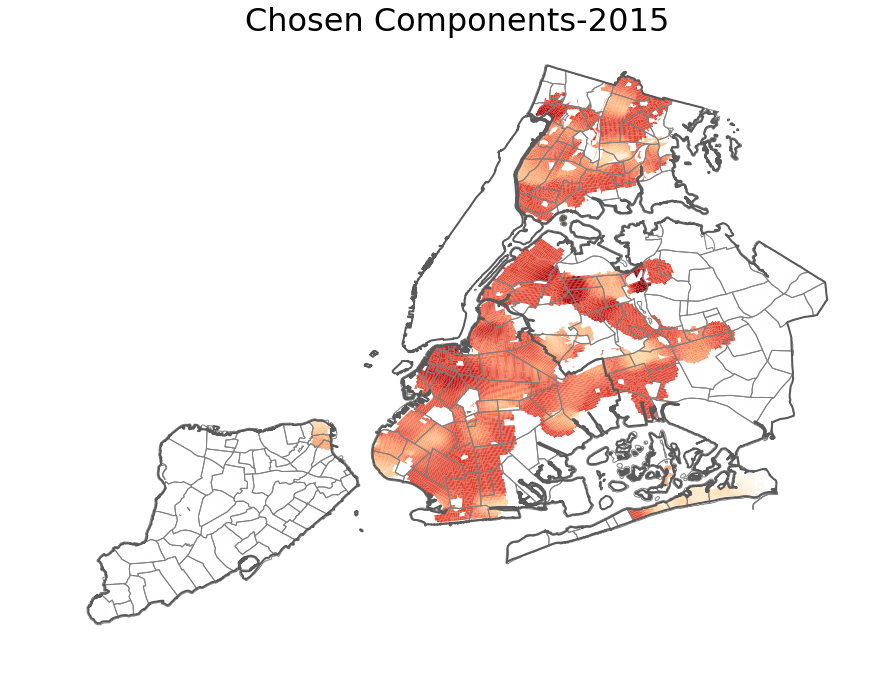

/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [22]:
comp_sum_2015 = B1_[:,0] + B1_[:,3] - B1_[:,1] - B1_[:,2] + B2_[:,0] + B2_[:,1] + B2_[:,3] - B2_[:,2] 
component_sum_2015 = get_vals_and_plot(comp_sum_2015, dist_mat, nyc_blk_map, 
                  nyc_nbhd_map, nyc_borough_map, "Chosen Components-2015",
                 'chosen_comps-2015', True)
component_sum_2015.to_file(main_path + '/Results/turnstile_vals_map-2015.shp')
component_sum_2015.to_csv(main_path + '/Results/turnstile_vals_map-2015.csv')

In [23]:
# get values for 2019 and map the difference
comp_sum_2019 = B1_2019[:,0] + B1_2019[:,3] - B1_2019[:,1] \
                    - B1_2019[:,2] + B2_2019[:,0] + B2_2019[:,1] + B2_2019[:,3] - B2_2019[:,2] 
diff_time_vals = comp_sum_2019 - comp_sum_2015

[10.]
[0.]


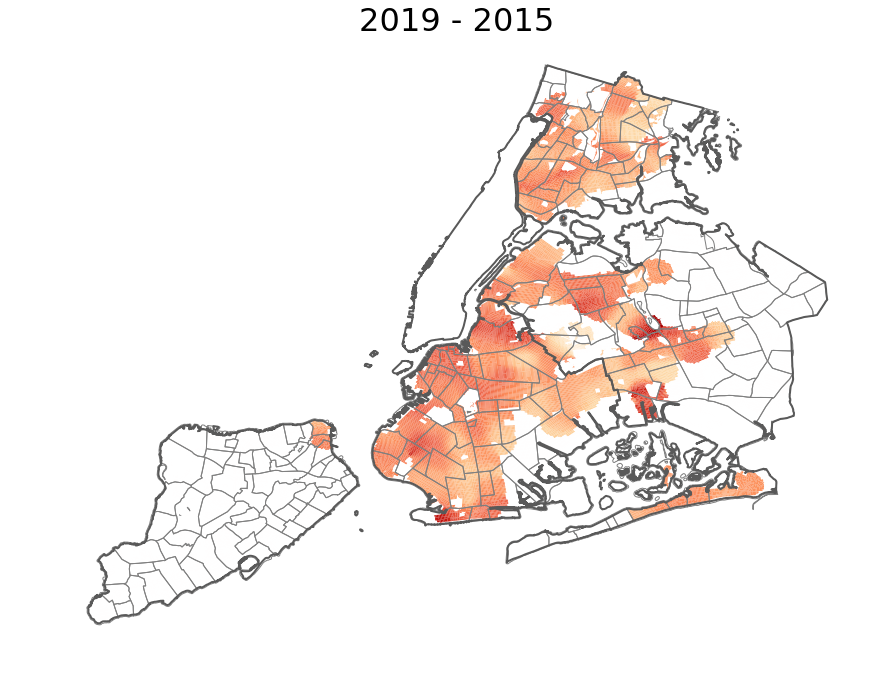

In [24]:
diff_time_vals_df = get_vals_and_plot(diff_time_vals, dist_mat, nyc_blk_map, 
                  nyc_nbhd_map, nyc_borough_map, "2019 - 2015",
                 'diff_turnstile', True)

## Contractor Permits

In [25]:
# load construction dataset and get year for each entry

construction_df = pd.read_csv(main_path + '/Data/Construction/DOB_Permit_Issuance.csv')
                              
def get_year(x):
    if isinstance(x, float):
        year = np.nan
    else:
        year = int(datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p').strftime('%Y'))
    return year

construction_df['Job_Start_Year'] = construction_df['Job Start Date'].map(get_year)
construction_df['Filing_Year'] = construction_df['Filing Date'].map(get_year)
construction_df['Issuance_Year'] = construction_df['Issuance Date'].map(get_year)

construction_df['Year'] = construction_df[['Job_Start_Year','Filing_Year','Issuance_Year']].max(axis=1)                              

/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1,8,9,10,15,25,31,33,34,35,36,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [53]:
# limit data to years of interest and outer boroughs
# get count by neighborhood
max_year = 2019
min_year = 2015

construction_df_filt = construction_df[(construction_df['Year'] > min_year) & \
                                           (construction_df['Year'] < max_year)]
construction_df_filt = construction_df_filt[construction_df_filt['BOROUGH'].isin(['QUEENS', 'BROOKLYN',
                                                                       'BRONX', 'STATEN ISLAND'])]
construction_df_filt = construction_df_filt.dropna(subset=['LONGITUDE', 'LATITUDE'])
construction_df_filt['geometry'] = construction_df_filt.apply(lambda row: 
                                                  Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
construction_df_filt = gpd.GeoDataFrame(construction_df_filt, geometry='geometry', crs=nyc_nbhd_map.crs)
construction_df_filt = gpd.tools.sjoin(construction_df_filt, nyc_nbhd_map, how='left')
construction_by_borough = construction_df_filt.groupby('Neighborhood').count()['BOROUGH']
construction_by_borough = construction_by_borough.rename('construction', axis=1)
construction_by_borough = construction_by_borough.to_frame()

In [54]:
# limit data to years of interest and outer boroughs
# get count by neighborhood
max_year = 1999
min_year = 1995
construction_df_filt = construction_df[(construction_df['Year'] > min_year) & \
                                           (construction_df['Year'] < max_year)]
construction_df_filt = construction_df_filt[construction_df_filt['BOROUGH'].isin(['QUEENS', 'BROOKLYN',
                                                                       'BRONX', 'STATEN ISLAND'])]
construction_df_filt = construction_df_filt.dropna(subset=['LONGITUDE', 'LATITUDE'])
construction_df_filt['geometry'] = construction_df_filt.apply(lambda row: 
                                                  Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
construction_df_filt = gpd.GeoDataFrame(construction_df_filt, geometry='geometry', crs=nyc_nbhd_map.crs)
construction_df_filt = gpd.tools.sjoin(construction_df_filt, nyc_nbhd_map, how='left')
construction_by_borough_older = construction_df_filt.groupby('Neighborhood').count()['BOROUGH']
construction_by_borough_older = construction_by_borough_older.rename('construction', axis=1)
construction_by_borough_older = construction_by_borough_older.to_frame()
construction_by_borough_older = construction_by_borough_older.rename(columns={'construction': 'construction_older'})



In [55]:
merged_construct = pd.concat([construction_by_borough
                              , construction_by_borough_older], axis=1)
merged_construct['ratio'] = merged_construct.construction/merged_construct.construction_older
merged_construct = merged_construct.reset_index().rename(columns={'index': 'Neighborhood'})

/Users/rita/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [74]:
# get mean of turnstile values by neighborhood
# exclude 0s
turnstile_df_to_correlate = diff_time_vals_df
turnstile_df_to_correlate = turnstile_df_to_correlate[turnstile_df_to_correlate.vals != 0]
turnstile_df_to_correlate = gpd.tools.sjoin(turnstile_df_to_correlate, nyc_nbhd_map, 
                                            how='left').groupby('Neighborhood').mean()['vals']
turnstile_df_to_correlate = turnstile_df_to_correlate.to_frame()

In [75]:
# merge construction and turnstile vals on neighborhood
merged_df = pd.merge(merged_construct.reset_index(), turnstile_df_to_correlate.reset_index(), 
         left_on='Neighborhood', right_on='Neighborhood')

In [76]:
merged_df

,index,Neighborhood,construction,construction_older,ratio,vals
0,3,Arverne,1267,141.0,8.985816,5.134296
1,4,Astoria,10303,3497.0,2.946240,4.623890
2,7,Bath Beach,2245,933.0,2.406217,4.738361
3,8,Bay Ridge,2453,896.0,2.737723,5.272487
4,10,Baychester,348,190.0,1.831579,2.901861
5,12,Bedford Park,1255,261.0,4.808429,4.171611
6,13,Bedford Stuyvesant,13339,3111.0,4.287689,4.754410
7,14,Belle Harbor,430,119.0,3.613445,4.161579
8,16,Belmont,903,349.0,2.587393,4.781518
9,17,Bensonhurst,3403,954.0,3.567086,4.678834


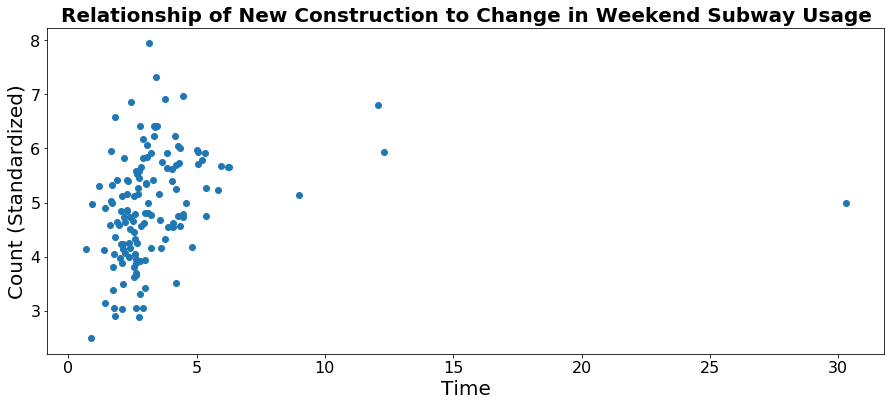

In [93]:
fig, ax = plt.subplots(1, figsize=(15,6))
matplotlib.pyplot.title('Relationship of New Construction to Change in Weekend Subway Usage', fontsize=20, fontweight='heavy')

plt.xlabel('Time', fontsize=20)
plt.ylabel('Count (Standardized)', fontsize=20)
matplotlib.pyplot.scatter(merged_df.ratio, merged_df.vals)
plt.savefig(main_path + '/Results/Pics/correlation1.png', dpi=300)
 

In [95]:
from scipy.stats import linregress
linregress(merged_df.ratio, merged_df.vals)

LinregressResult(slope=0.07951580472996034, intercept=4.658460809976496, rvalue=0.2241091565250336, pvalue=0.00847165130353669, stderr=0.0297603037690344)

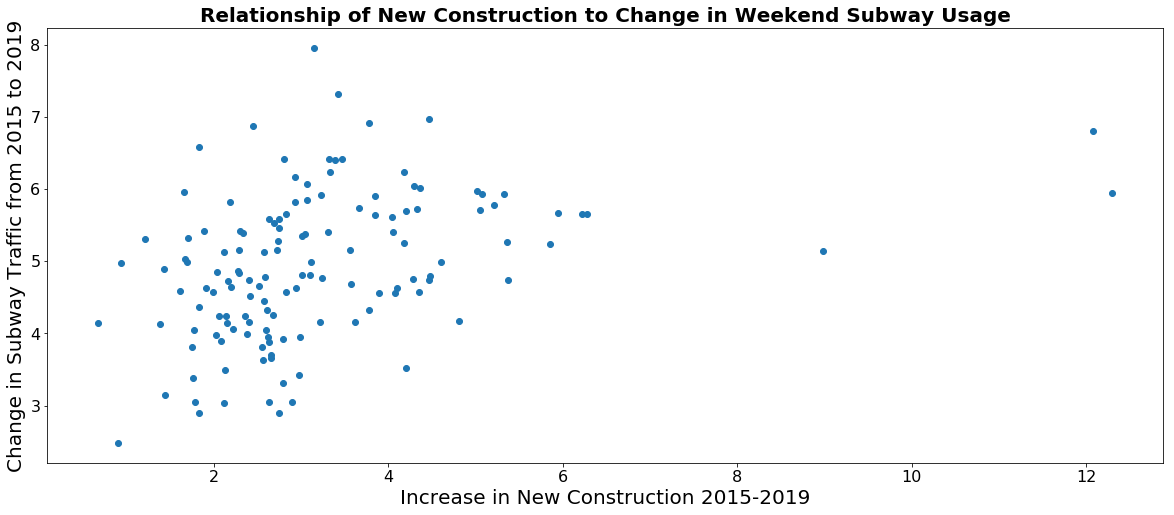

In [105]:
merged_df = merged_df[merged_df.ratio < 25]

fig, ax = plt.subplots(1, figsize=(20,8))
matplotlib.pyplot.title('Relationship of New Construction to Change in Weekend Subway Usage', fontsize=20, fontweight='heavy')

plt.xlabel('Increase in New Construction 2015-2019', fontsize=20)
plt.ylabel('Change in Subway Traffic from 2015 to 2019', fontsize=20)
matplotlib.pyplot.scatter(merged_df.ratio, merged_df.vals)
plt.savefig(main_path + '/Results/Pics/correlation1.png', dpi=300)
 

In [97]:
linregress(merged_df.ratio, merged_df.vals)

LinregressResult(slope=0.23044710595884402, intercept=4.191153906724722, rvalue=0.37785202451799, pvalue=5.757981081069685e-06, stderr=0.04878038697422507)

In [107]:
min(merged_df.vals)

2.487576809375848

In [101]:
merged_df.sort_values(by=['ratio'], ascending=False)

,index,Neighborhood,construction,construction_older,ratio,vals
79,123,Marble Hill,123,10.0,12.300000,5.940407
33,54,DUMBO,966,80.0,12.075000,6.800176
0,3,Arverne,1267,141.0,8.985816,5.134296
66,105,Hunters Point,4100,653.0,6.278714,5.658452
103,165,Prospect Lefferts Gardens,1854,298.0,6.221477,5.650055
105,167,Prospect Park South,113,19.0,5.947368,5.666656
23,43,Clinton Hill,2926,500.0,5.852000,5.236195
42,68,Far Rockaway,4065,757.0,5.369881,4.745110
135,219,Windsor Terrace,847,158.0,5.360759,5.264556
27,48,Columbia Street Waterfront District,559,105.0,5.323810,5.924858
